### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Visualización

Integrantes:

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 4 de julio de 2021

In [ ]:
#!conda install -y -c conda-forge spacy=3.0.6

In [ ]:
!python -m spacy validate

In [ ]:
#!python -m spacy download es_core_news_md

In [74]:
import pandas as pd
import spacy
import datetime
from spacy.tokens.doc import Doc
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams

import lib.nlp_cba as nlp_cba
import lib.graph_cba as graph_cba

In [23]:
print(spacy.__version__)

3.0.6


In [24]:
#Nombre con el cual se graba el data frame corpus de todas las sentencias. Cada sentencia es una fila
corpus_file_name = "corpus.csv"

#Nombre con el cual se graba el data frame que tiene el corpus sumarizado por fuero. Todo el texto de las sentencias de un
# fuero esta en una sola fila
agregated_corups_df_file_name = "agregated_corpus.csv"


load_from_pickle = True

In [25]:
print (f"El data frame corpus_df se carga desde el archivo {corpus_file_name}")
corpus_df = pd.read_csv(corpus_file_name)

El data frame corpus_df se carga desde el archivo corpus.csv


In [26]:
print (f"El data frame agregated_corups_df se carga desde el archivo {agregated_corups_df_file_name}")
agregated_corups_df = pd.read_csv(agregated_corups_df_file_name)

El data frame agregated_corups_df se carga desde el archivo agregated_corpus.csv


In [27]:
corpus_df.head()

,text,classifier,id
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES,4de122c24ab1606c9d67f4ff9e656143
1,unívoco 18900 fecha 04/04/2016 materia niñe...,Documentos/MENORES,1f9cdcb2c2596656b540c1271fc2d843
2,13/03/2013 juzgado de la niñez juventud y vio...,Documentos/MENORES,17dcae14592fc6e87680ccb4251d9395
3,los autos caratulados a. a. - denuncia...,Documentos/MENORES,4b3ae58648b6267ebb332feec8002588
4,juzg. de niñez adolescencia y violencia famil...,Documentos/MENORES,1316026beaa1d7e6530bdfe7e54f7b5c


In [28]:
agregated_corups_df.head()

,text,classifier
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES
1,sala penal - tribunal superior protocolo de s...,Documentos/PENAL
2,auto número sesenta y seis córdoba cinco de...,Documentos/FAMILIA
3,sala laboral - tribunal superior protocolo de...,Documentos/LABORAL


## Nomalización de Texto

In [29]:
#Cargamos el lenguaje español en spacy
spacy_nlp = spacy.load("es_core_news_md") 
spacy_nlp.max_length = 5000000

Doc.set_extension('document_id', default=False, force=True)
Doc.set_extension('classifier', default=False, force=True)


In [30]:
#Vemos las STOP_WORDS que viene definidas por defecto
#spacy.lang.es.stop_words.STOP_WORDS

In [31]:
# Stop_words que no estan contempladas en Spacy y consideramos necesario sacarlas

customs_stop_words = ['y' , 'a', 'e' , 'o' , 'u']


for custom_stop_word in customs_stop_words:
    spacy_nlp.vocab[custom_stop_word].is_stop = True
    spacy.lang.es.stop_words.STOP_WORDS.add(custom_stop_word)

#spacy.lang.es.stop_words.STOP_WORDS

Clases para filtrar y transformar datos en Spacy

In [32]:
class SpacyTextNormalizer:
    def __init__(self):
        
        self.filters = []
        self.transformers = []
        self.documents = []
        
    def addFilter(self, filter):
        self.filters.append(filter)
        
    def addTransformer(self, transformer):
        self.transformers.append(transformer)
        
    
    def fit(self , spacy_tuples):
        self.documents = []
        for doc,context in spacy_tuples:
            
            doc._.document_id = context["document_id"]
            doc._.classifier = context["classifier"]
            self.documents.append(doc)
        
        
    def normalize(self, filters = [], transformers = []):
        documents = []
        for doc in self.documents:
            words = []
            
            for word in doc:
                include = True

                for filter in filters:
                    include = filter.execute(word)
                    if not include: 
                        break
        
                if include:
                    
                    transformed_res = []
                    transformed_res.append(word)
                    
                    for transformer in transformers:
                        transformed_res.append(transformer.transform(word))
                        
                    words.append(transformed_res)       
        
            documents.append(( doc ,words))
        
        return documents

In [33]:
class MapMultipleCharsProcessor:

    def process(self, text , replace_chars):
        
        for ch in replace_chars:
            text = text.replace(ch[0],ch[1])

        
        return text

In [35]:
class Timer:
    
    def start(self):
        self.start_ = datetime.datetime.now()
        
    def stop(self):
       
        self.stop_ = datetime.datetime.now()
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

    def print_stats(self):
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

timer = Timer()

In [36]:
chars_replace = [('á' , 'a') , ('é' , 'e') , ('í', 'i') , ('ó' , 'o') , ('ú' , 'u')]
mapMultipleCharsProcessor = MapMultipleCharsProcessor()
mapMultipleCharsProcessor.process("Holá ú esté" , chars_replace)

'Hola u este'

In [37]:
class RemoveStopWordsFilter:
    def execute(self, word):
        return not word.is_stop 

class RemovePuntctuationFilter:
    def execute(self, word):
        return not word.is_punct
    
class RemoveSpaceFilter:
    def execute(self, word):
        return not word.is_space
    
    
class ToLowerCaseTransformer:
    def transform(self, word):
        return word.lower_
    
class ToLemaTransformer:
    def transform(self, word):
        return mapMultipleCharsProcessor.process(word.lemma_ , chars_replace)
    

Filtros y transformes que vamos a utilizar para normalizar los datos

In [38]:
#Filtros y transformers

removeSpaceFilter = RemoveSpaceFilter()
removeStopWordsFilter = RemoveStopWordsFilter()
removePuntctuationFilter = RemovePuntctuationFilter()

toLowerCaseTransformer = ToLowerCaseTransformer()
toLemaTransformer = ToLemaTransformer()

In [39]:
# Prueba de filtros y transformers
texto = [
    ("Esta es una pregunta? Tenes que llamar a Christian y a Gonzalo", {"document_id": "1" , "classifier" : "PENAL"} )
    ]

doc_tuples = spacy_nlp.pipe(texto , as_tuples=True , n_process=-1  )


spacyTextNormalizer = SpacyTextNormalizer()

spacyTextNormalizer.fit(doc_tuples)
result = spacyTextNormalizer.normalize(transformers=[toLemaTransformer] , filters=[removeStopWordsFilter , removePuntctuationFilter ])

In [40]:
result

[(Esta es una pregunta? Tenes que llamar a Christian y a Gonzalo,
  [[pregunta, 'pregunta'],
   [Tenes, 'ten'],
   [llamar, 'llamar'],
   [Christian, 'Christian'],
   [Gonzalo, 'Gonzalo']])]

In [41]:
# Extremadamente lento este enfoque para el caso de procesar el copus por fuero. El length del string del texto del corpus es 'grande' y 
# hace que sea lento el procesamiento
# Código deprecado

if False:
    texto = [(agregated_corups_df.iloc[2,].text , {"text_id": "1"})]

    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4 , disable=["tok2vec", "tagger",  "attribute_ruler"] )

    result = spacyTextNormalizer.normalize(doc_tuples)

In [42]:
#Armamos el array de tuplas a partir del data frame corpus_df. Usamos este data frame y no el agregated_corups_df puesto
# que el array de texto por tupla es muy grande y Spacy requiere más memoria ademas de se notablemente lento

#load_from_pickle = False
if not load_from_pickle:

    texto = corpus_df.apply( lambda x : (x['text'] , {"document_id": x['id'] ,"classifier" : x["classifier"] }) , axis=1)
    timer.start()
    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4  )

    spacyTextNormalizer.fit(doc_tuples)
    timer.stop()

In [43]:
# Poniendo a True serealizamos la instancia spacyTextNormalizer. Esto no permite reconstruir el objeto por medio del
# archivo serealizado. Levantar el archivo y recrear el objeto es mucho más rápido de recostruir el objeto usando nlp.pipe y fit
if False:
    filehandler = open("normilizer.pkl", 'wb') 
    pickle.dump(spacyTextNormalizer, filehandler)

In [45]:
#Recreamos el objeto spacyTextNormalizer desde un archivo, ver la explicación del punto anterior

#load_from_pickle = True

if load_from_pickle:
    
    timer.start()
    filehandler = open("normilizer.pkl", 'rb') 
    spacyTextNormalizer = pickle.load(filehandler)
    timer.stop()
    

Tiempo de procesamiento: 0:00:10.018524


In [46]:
timer.start()

filters = [removeSpaceFilter,removeStopWordsFilter ,removePuntctuationFilter]

transformers = [toLemaTransformer]

result = spacyTextNormalizer.normalize(filters=filters, transformers=transformers)

timer.stop()

Tiempo de procesamiento: 0:00:03.108317


In [47]:
result[242][0]._.document_id

'bc6b79c0bfd70165dd19eee02a897443'

In [93]:
def get_words_list(document):
    words = [ word[1] for word in document]
    return words
    

def get_word_count_df(document ,ngram_cardinality = [1] ):

    result = []
    
    for ngram in ngram_cardinality:
        words = get_words_list(document)
        
        if ngram != 1:
            words = ngrams(words, ngram)
           
        counter = Counter (words)
        
        most_common_words = []
        for word in counter.most_common():
            most_common_words.append(word + (ngram,))
        
        result = result + most_common_words
    
    #return pd.DataFrame(data = counter.most_common()  , columns= [ "word" , "count"])
    return pd.DataFrame(data = result  , columns= [ "word" , "count" , "ngram"])


    

def create_corpus_df(documents , ngram_cardinality = [1]):

    column_names = ["word", "count", "id" , "classifier"]

    merged_df = pd.DataFrame(columns = column_names)

    for document in documents:

        doc_df = get_word_count_df(document[1] , ngram_cardinality)
        doc_df['id'] = document[0]._.document_id
        doc_df['classifier'] = document[0]._.classifier
        merged_df = merged_df.append(doc_df, ignore_index = True)


    return merged_df

In [94]:
# Se crea DF con conteo de palabras
timer.start()
df_corpus = create_corpus_df(result , ngram_cardinality=[1])
timer.stop()
df_corpus

Tiempo de procesamiento: 0:00:04.903649


,word,count,id,classifier,ngram
0,m.,29,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
1,ley,24,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
2,violencia,23,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
3,medida,22,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
4,familiar,20,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
...,...,...,...,...,...
224110,mario,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
224111,martin,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
224112,lascano,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
224113,eduardo,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0


In [95]:
# Se crea DF con conteo de ngramas
timer.start()
df_corpus_nagram = create_corpus_df(result , ngram_cardinality=[2,3])
timer.stop()
df_corpus_nagram

Tiempo de procesamiento: 0:00:20.074154


,word,count,id,classifier,ngram
0,"(violencia, familiar)",14,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
1,"(m., c.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
2,"(sr, m.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
3,"(c., m.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
4,"(sra, s.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
...,...,...,...,...,...
973103,"(javier, fecha, 2020.02.18)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
973104,"(fecha, 2020.02.18, expediente)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
973105,"(2020.02.18, expediente, nro)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
973106,"(nro, 3240353, 8)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0


In [96]:
def get_grouped_df_by_classifier(df_corpus , classifier = "ALL"):
    
    if classifier == "ALL":
        df_grouped = df_corpus.groupby(['word'] , as_index=False).agg({'count': ['sum']})
    else:
        df_grouped = df_corpus[df_corpus['classifier'] == classifier].groupby(['word'] , as_index=False).agg({'count': ['sum']})

    df_grouped = df_grouped.sort_values(by=[('count' , 'sum')],ascending = False)[:50]
    df_grouped.droplevel(axis=1, level=0).reset_index()
    df_grouped.columns  =[ "word", "count"]
    return df_grouped

In [97]:
timer.start()

df_menores = get_grouped_df_by_classifier(df_corpus , 'Documentos/MENORES')
df_laboral = get_grouped_df_by_classifier(df_corpus , 'Documentos/LABORAL')
df_penal = get_grouped_df_by_classifier(df_corpus , 'Documentos/PENAL')
df_familia = get_grouped_df_by_classifier(df_corpus , 'Documentos/FAMILIA')
df_all = get_grouped_df_by_classifier(df_corpus )
timer.stop()

Tiempo de procesamiento: 0:00:08.749237


In [98]:
df_all[:4]

,word,count
8326,art,4332
15295,fs,4284
18419,ley,3123
8688,auto,2644


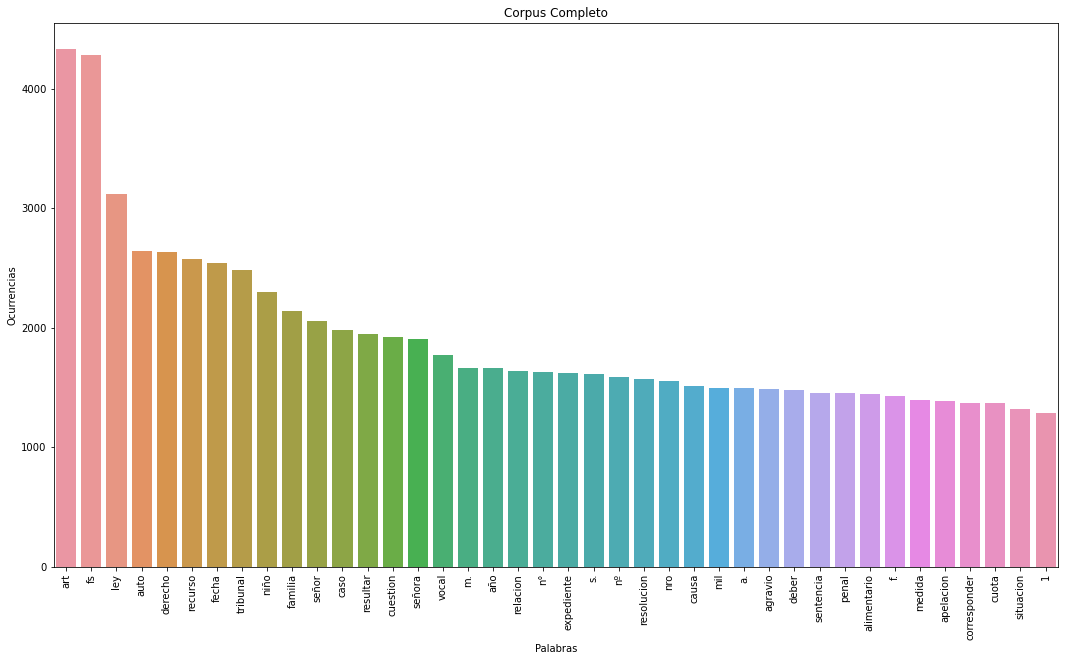

In [99]:
limit_to_plot=40

fig, axes = plt.subplots(1, 1 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes, x = "word" , y = "count", df = df_all ,title ="Corpus Completo" , limit_to_plot = limit_to_plot  )

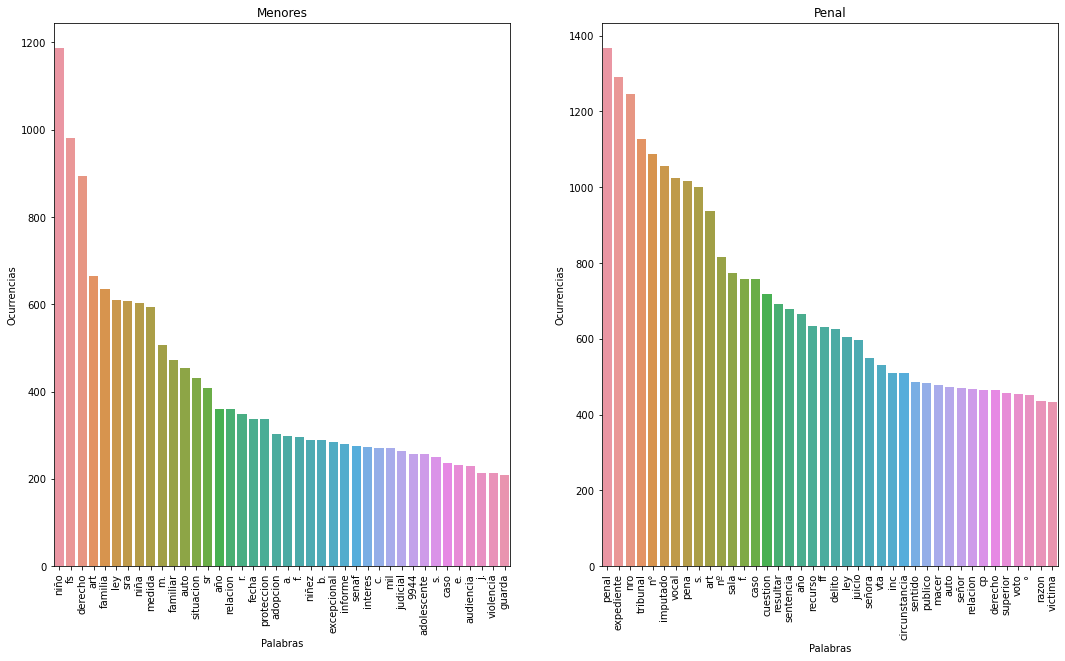

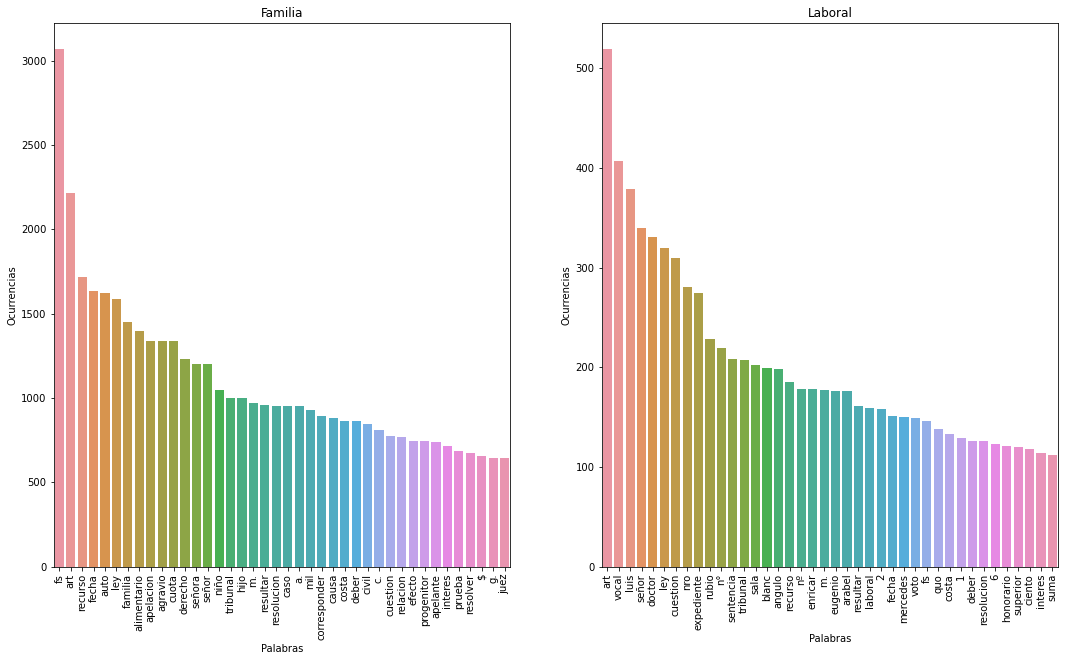

In [100]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral ,title ="Laboral" , limit_to_plot = limit_to_plot )

In [106]:
timer.start()

df_menores_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/MENORES')
df_laboral_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/LABORAL')
df_penal_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/PENAL')
df_familia_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/FAMILIA')

timer.stop()

Tiempo de procesamiento: 0:00:36.813923


In [ ]:
df_menores[:10]

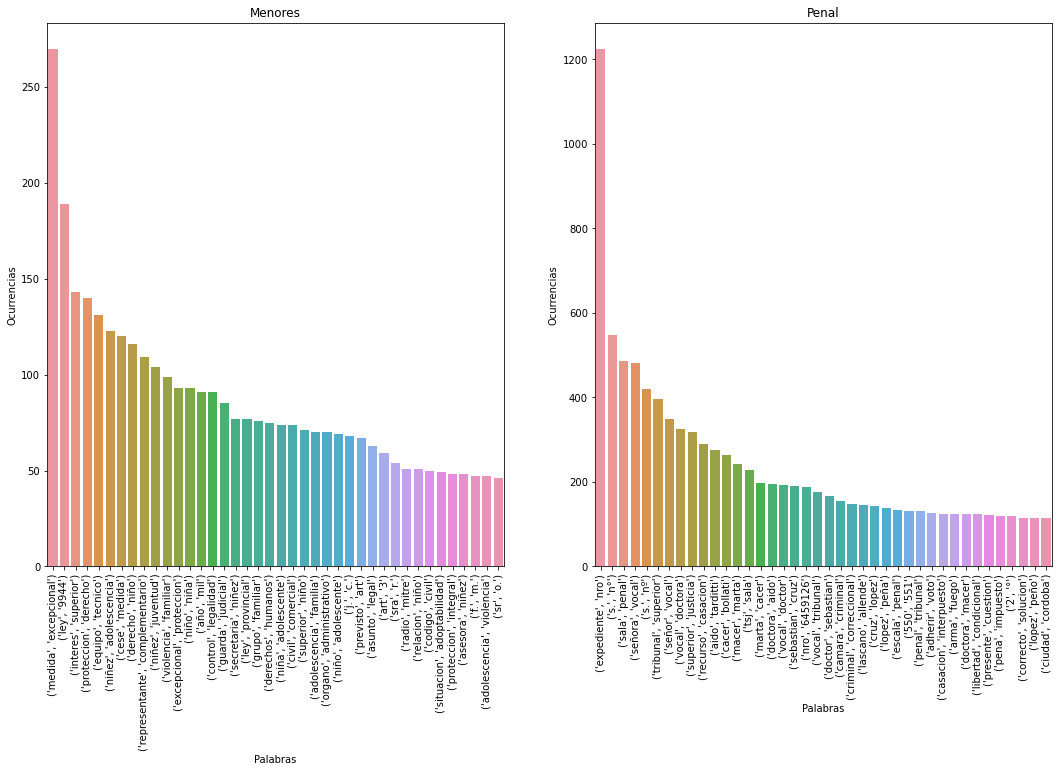

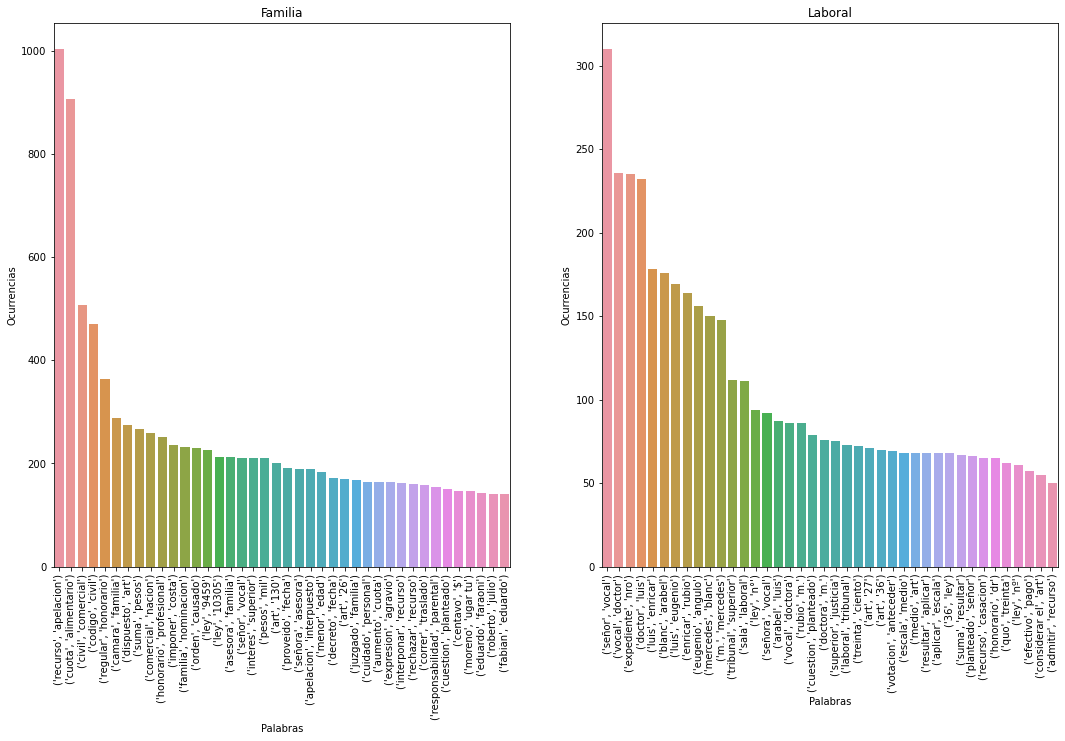

In [107]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores_ngram ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal_ngram ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia_ngram ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral_ngram ,title ="Laboral" , limit_to_plot = limit_to_plot )

## Prueba Varias

In [101]:
#Guardamos información de contexto del documento
spacy.tokens.doc.Doc.set_extension('text_id' , default =False , force = True)
doc_tuples = spacy_nlp.pipe([("Hola esto es una prueba que te parece" , {"text_id" : "text_id1_1"})] , as_tuples=True , n_process=-1)
docs = []

for doc, context in doc_tuples:
    doc._.text_id = context["text_id"]
    docs.append(doc)

In [ ]:
for doc in docs:
    for token in doc:
        print(f"ddd.{token.text} {token.is_sent_start}  {token.lemma_} {token.norm_} {token.pos_}{doc._.text_id} ")